In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import pandas as pds
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset_dir = ('../input/imagesoasis/Data')

categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented','Very mild Dementia']

data = []
labels = []

class_counts = {category: 0 for category in categories}

for category in categories:
    path = os.path.join(dataset_dir, category)
    num_images = len(os.listdir(path))
    class_counts[category] = num_images
    print(f"Number of images in {category}: {num_images}")

print("\nTotal number of images:")
for category, count in class_counts.items():
    print(f"{category}: {count}")


Number of images in Mild Dementia: 5002
Number of images in Moderate Dementia: 488
Number of images in Non Demented: 67222
Number of images in Very mild Dementia: 13725

Total number of images:
Mild Dementia: 5002
Moderate Dementia: 488
Non Demented: 67222
Very mild Dementia: 13725


In [4]:
import random
dataset_dir = ('../input/imagesoasis/Data')

categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented','Very mild Dementia']

# Set a seed for reproducibility
random.seed(50)

data = []
labels = []
undersampled_class_counts = {category: 0 for category in categories}

# Set the desired number of images for undersampling
num_undersample_non_demented = 9000
num_undersample_very_mild_dementia = 7000

for category in categories:
    path = os.path.join(dataset_dir, category)
    num_images = len(os.listdir(path))
    class_num = categories.index(category)

    # For 'Non Demented', limit the number of images
    if category == 'Non Demented':
        images = random.sample(os.listdir(path), min(num_undersample_non_demented, num_images))
    elif category == 'Very mild Dementia':
        images = random.sample(os.listdir(path), min(num_undersample_very_mild_dementia, num_images))
    else:
        images = os.listdir(path)
        
    undersampled_class_counts[category] = len(images)

    print(f"Number of images in {category}: {undersampled_class_counts[category]}")    

    for img in images:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array = cv2.resize(img_array, (224, 224))  # Resize the image to 224x224
        data.append([img_array, class_num])

np.random.shuffle(data)


Number of images in Mild Dementia: 5002
Number of images in Moderate Dementia: 488
Number of images in Non Demented: 9000
Number of images in Very mild Dementia: 7000


In [5]:
len(data)

21490

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

y = to_categorical(y, num_classes=len(categories))

n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)

for train_index, test_index in stratified_split.split(X,y):
  X_t, X_test = X[train_index], X[test_index]
  y_t, y_test = y[train_index], y[test_index]

In [36]:
len(X_t)


17192

In [37]:
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [56]:
from collections import Counter

train_class_counts = Counter(np.argmax(y_train, axis=1))

val_class_counts = Counter(np.argmax(y_val, axis=1))

test_class_counts = Counter(np.argmax(y_test, axis=1))

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 3: 4480 samples
Class 0: 3201 samples
Class 2: 5760 samples
Class 1: 312 samples

Validation Set Class Counts:
Class 2: 1440 samples
Class 0: 801 samples
Class 3: 1120 samples
Class 1: 78 samples

Test Set Class Counts:
Class 2: 1800 samples
Class 3: 1400 samples
Class 0: 1000 samples
Class 1: 98 samples


In [57]:
print(len(X_train),len(X_test),len(X_val),len(X_t))

13753 4298 3439 17192


In [90]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch,lr):
    if epoch < 4:
        return lr
    else:
        return 0.95*lr

In [91]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [92]:
optimizer = Adam(learning_rate=0.00095)

In [93]:
from keras import layers
from keras import models

In [94]:
import tensorflow as tf

In [95]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

def create_vgg16(input_shape, n_classes):
    """
    Create VGG16 model without Global Average Pooling.

    Args:
        input_shape (tuple): Shape of input images (height, width, channels).
        n_classes (int): Number of classes for classification.

    Returns:
        tf.keras.Model: Created VGG16 model.
    """
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    return model

input_shape = (224, 224, 3)
num_classes = 4
model = create_vgg16(input_shape, num_classes)

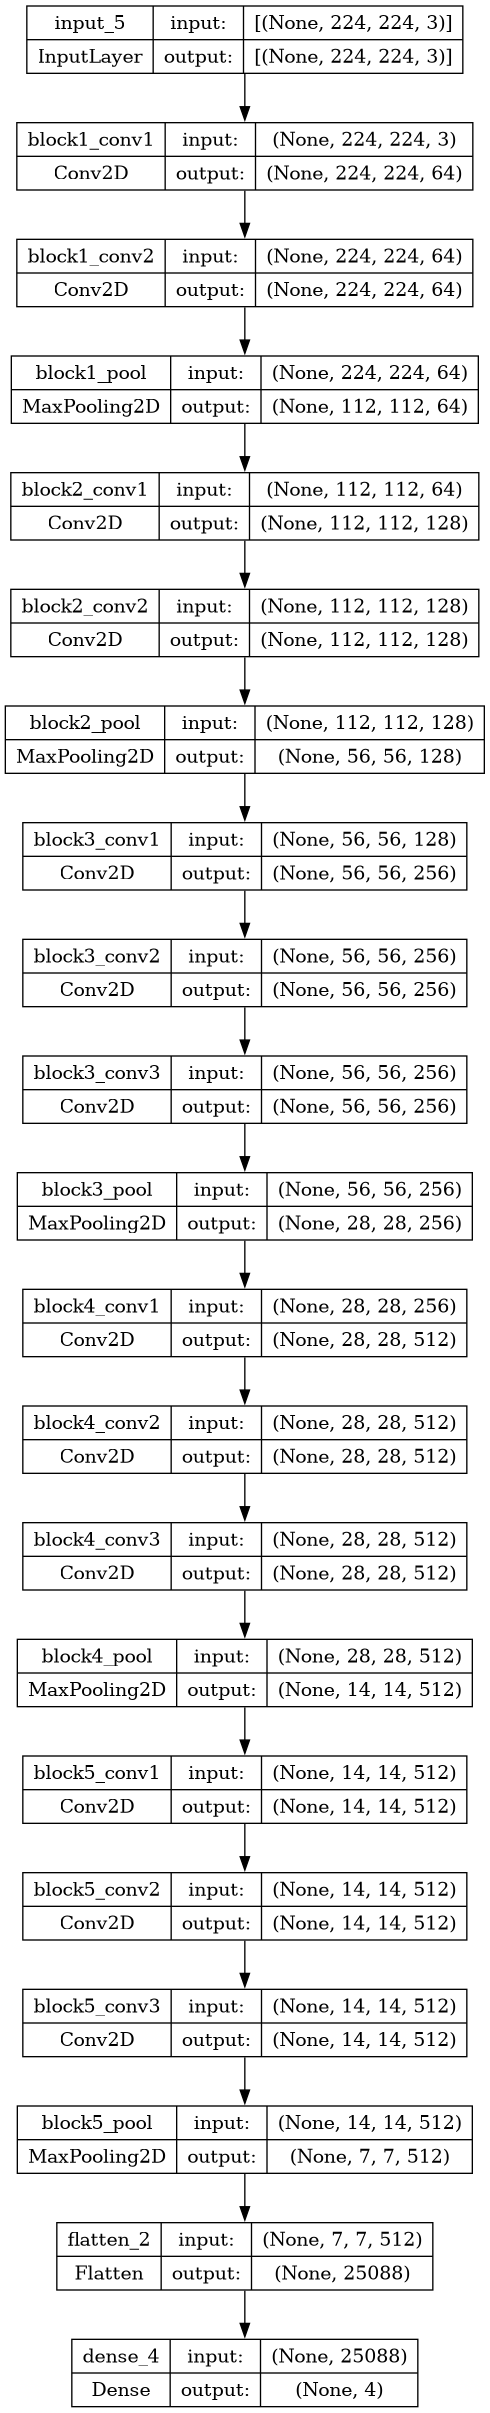

In [96]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [97]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [98]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',create_metrics()])

In [99]:
from keras.callbacks import ReduceLROnPlateau, LambdaCallback
from keras import backend as K
lr_history = []

def record_lr(epoch, logs):
    lr_history.append(model.optimizer.lr.numpy())

lr_recorder = LambdaCallback(on_epoch_end=record_lr)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    validation_data=(X_val, y_val),
    epochs=7 # or however many epochs you wish to train for
#     callbacks=[lr_scheduler]
#     class_weight=class_weights
    
)



Epoch 1/7
215/215 [==============================] - 94s 414ms/step - loss: 3.6366 - accuracy: 0.4053 - precision_5: 0.4013 - recall_5: 0.0617 - f1_score: 0.0846 - specificity: 0.9693 - sensitivity: 0.0618 - mcc: 0.0639 - auc_5: 0.6915 - val_loss: 1.2186 - val_accuracy: 0.4286 - val_precision_5: 0.6667 - val_recall_5: 5.8156e-04 - val_f1_score: 0.0015 - val_specificity: 0.9999 - val_sensitivity: 7.8802e-04 - val_mcc: 0.0023 - val_auc_5: 0.7153
Epoch 2/7
215/215 [==============================] - 87s 406ms/step - loss: 1.3338 - accuracy: 0.4168 - precision_5: 0.4373 - recall_5: 0.0089 - f1_score: 0.0101 - specificity: 0.9962 - sensitivity: 0.0089 - mcc: 0.0064 - auc_5: 0.7020 - val_loss: 1.2939 - val_accuracy: 0.4187 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_specificity: 1.0000 - val_sensitivity: 0.0000e+00 - val_mcc: 0.0000e+00 - val_auc_5: 0.7135
Epoch 3/7
215/215 [==============================] - 87s 406ms/step - loss: 1.2685 - accurac

#### Use this for mixed data testing

In [100]:
result = model.evaluate(X_test, y_test)

135/135 [==============================] - 8s 62ms/step - loss: 3362185.5000 - accuracy: 0.4197 - precision_5: 0.6000 - recall_5: 0.0014 - f1_score: 0.0044 - specificity: 0.9990 - sensitivity: 0.0044 - mcc: 0.0035 - auc_5: 0.7138         


In [101]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=categories)

print(report)


135/135 [==============================] - 8s 58ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.00      0.00      0.00      1000
 Moderate Dementia       0.00      0.00      0.00        98
      Non Demented       0.42      1.00      0.59      1800
Very mild Dementia       0.60      0.00      0.01      1400

          accuracy                           0.42      4298
         macro avg       0.25      0.25      0.15      4298
      weighted avg       0.37      0.42      0.25      4298



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


108/108 [==============================] - 6s 59ms/step


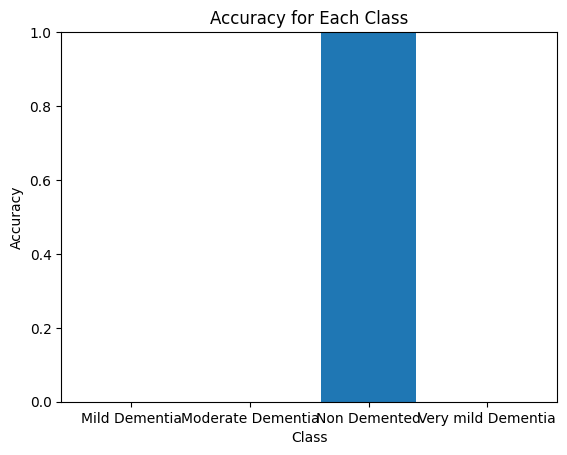

In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plotting
plt.bar(categories, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim([0, 1])  # Set the limit of y-axis to [0,1] for percentage
plt.show()


In [103]:
from keras.metrics import Precision, Recall, AUC

In [104]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

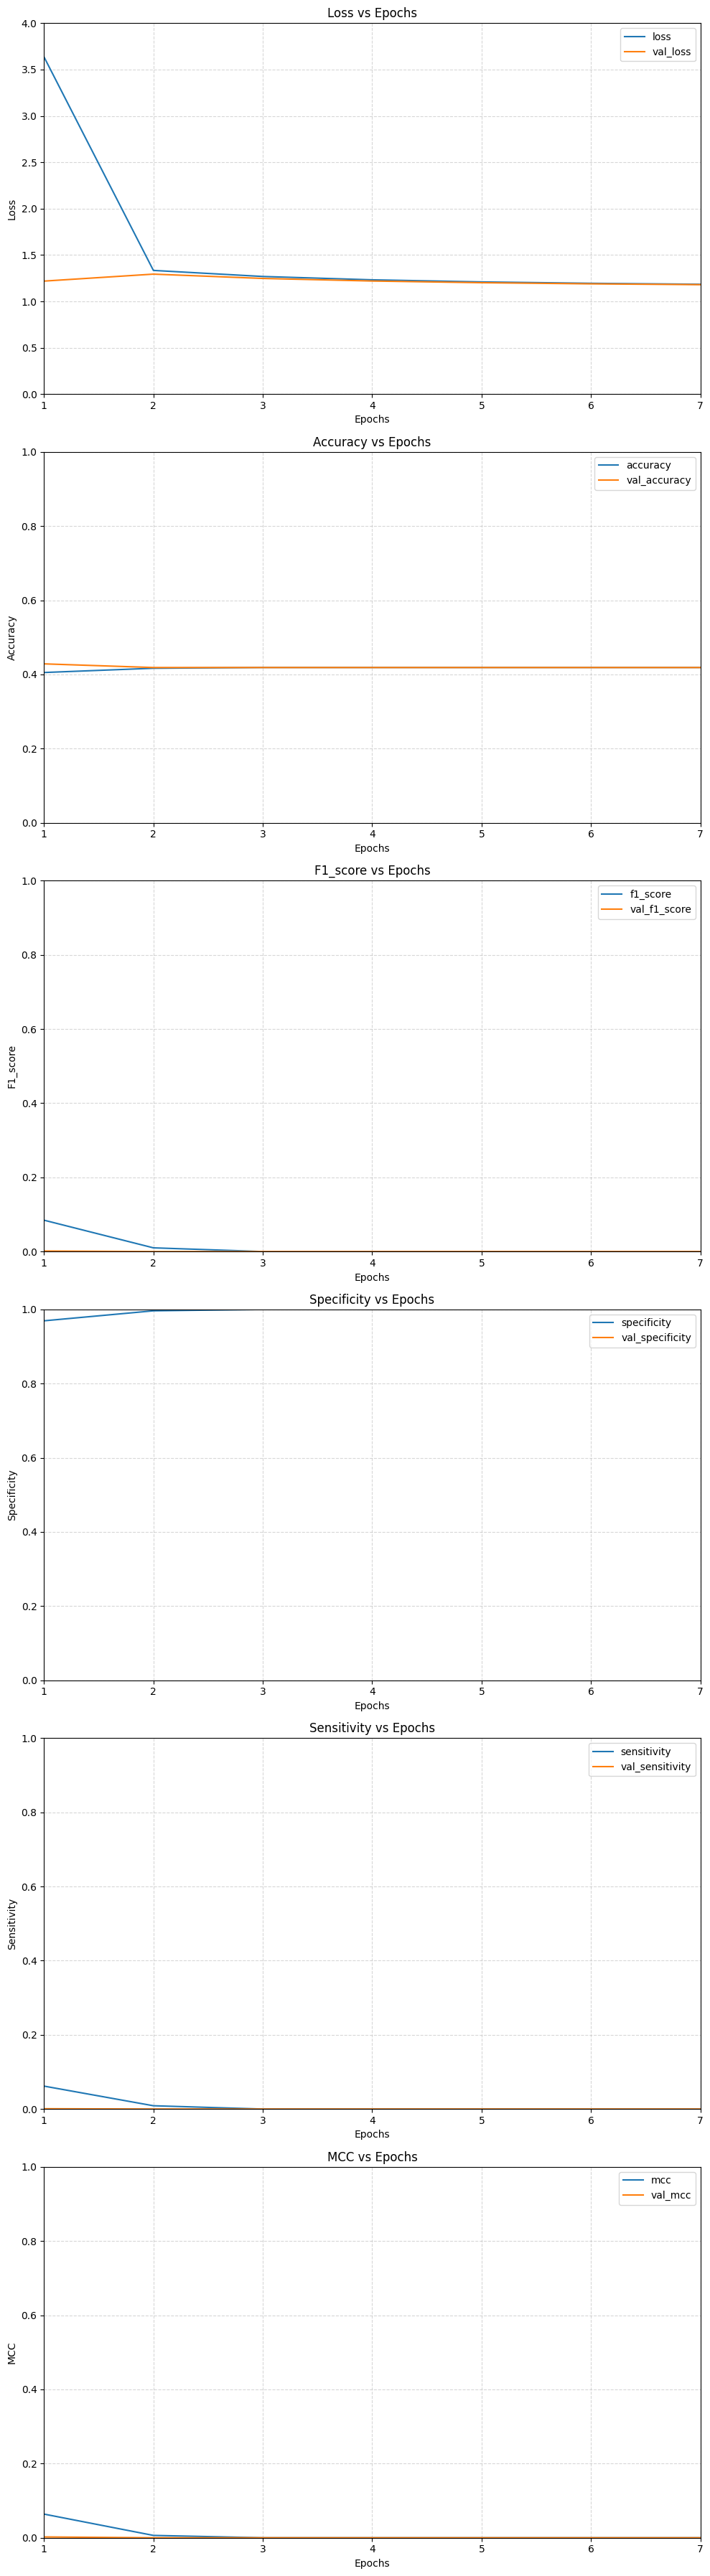

In [105]:
import math
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)